# Anime faces genertion

Generating animefaces at the resolution of 128px using a modified ProGAN architecture <br>
The Frechet Inception Distance (FID) calculated from 50000 generated images at 128px with respect to the full training dataset is 6.94

Link to the dataset: https://www.kaggle.com/datasets/dimensi0n/anime-faces-dataset

References: <br>
[1] https://github.com/tkarras/progressive_growing_of_gans <br>
[2] https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/ProGAN <br>
[3] https://www.kaggle.com/code/theoviel/conditional-progan-30-public

Use the implementatin of clean-fid to monitor FID during training <br>
Link: https://github.com/GaParmar/clean-fid

In [ ]:
! pip install clean-fid

In [ ]:
from cleanfid import fid

In [ ]:
from math import log2
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import shutil
import pandas as pd

In [ ]:
def show_tensor_images(image_tensor, num_images=10, nrow=5, figsize=(12,12)):
    image_clipped = torch.clamp(image_tensor, min=-1.0, max=1.0)
    image_shifted = (image_clipped + 1) / 2
    image_grid = make_grid(image_shifted[:num_images].detach().cpu(), nrow=nrow)
    plt.figure(figsize = figsize)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
DATASET                 = '/content/dataset'
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [16, 16, 16, 16, 16, 16]
image_size              = 128
CHANNELS_IMG            = 3
Z_DIM                   = 512  
IN_CHANNELS             = 512
GAMMA                   = 10
PROGRESSIVE_EPOCHS      = [20, 40, 40, 40, 40, 40]

In [ ]:
if not os.path.exists('dataset_copy'):
    os.makedirs('dataset_copy')

In [ ]:
for name in tqdm(os.listdir('dataset')):
    shutil.copy(os.path.join('dataset', name), os.path.join('dataset_copy', name))

In [ ]:
print("Number of images for training: {}".format(len(os.listdir('dataset'))))

Number of images for training: 40603


In [ ]:
class AnimeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, transform): 
        def get_images():
            images = [x for x in os.listdir('dataset') if x.lower().endswith('png')]
            return images
          
        self.images = get_images()
        self.transform = transform
        
            
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join('dataset', image_name)
        image = Image.open(image_path)
        return self.transform(image)

In [ ]:
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = AnimeFacesDataset(transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset

In [ ]:
loader, dataset = get_loader(128)

Images used for training:


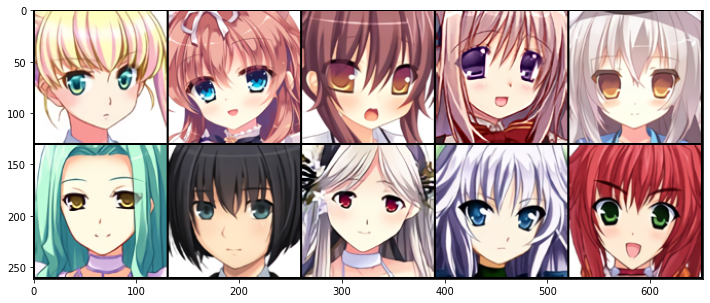

In [ ]:
dataiter = iter(loader)
images = next(dataiter)
print("Images used for training:")
show_tensor_images(images)

Custom layers

In [ ]:
class ELConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ELConv2d, self).__init__()
        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding
        self.fan_in = in_channels * kernel_size * kernel_size
        self.scale = (2 / self.fan_in) ** (0.5)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return F.conv2d(input=x,
                        weight=self.weight * self.scale,
                        bias=self.bias,
                        stride=self.stride,
                        padding=self.padding)
      
class ELLinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ELLinear, self).__init__()
        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.fan_in = in_channels
        self.scale = (2 / self.fan_in) ** (0.5)

    def forward(self, x):
        return F.linear(input=x,
                        weight=self.weight * self.scale,
                        bias=self.bias)
        
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

class MiniBatchSTD(nn.Module):
    def __init__(self):
        super(MiniBatchSTD, self).__init__()
        self.alpha = 1e-8

    def forward(self, x):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2).mean(dim=0, keepdim=False) + self.alpha)
        y = y.mean()
        y = y.repeat(batch_size, 1, height, width)
        y = torch.cat([x, y], 1)
        return y

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = ELConv2d(in_channels, out_channels)
        self.conv2 = ELConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        self.initial_block = nn.Sequential(
            PixelNorm(),
            ELLinear(z_dim, in_channels * 4 * 4),
            nn.Unflatten(1, (in_channels, 4, 4)),
            nn.LeakyReLU(0.2),
            PixelNorm(),
            ELConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )  # 4
        
        self.prog_blocks = nn.ModuleList([
            ConvBlock(in_channels, in_channels),              # 8
            ConvBlock(in_channels, in_channels),              # 16
            ConvBlock(in_channels, in_channels),              # 32
            ConvBlock(in_channels, in_channels // 2),         # 64
            ConvBlock(in_channels // 2, in_channels // 4),    # 128
        ])

        self.to_rgb_layers = nn.ModuleList([
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 4
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 8
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 16
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 32
            ELConv2d(in_channels // 2, img_channels, kernel_size=1, stride=1, padding=0),   # 64
            ELConv2d(in_channels // 4, img_channels, kernel_size=1, stride=1, padding=0),   # 128
        ])

    def forward(self, x, alpha, steps):
        assert alpha >= 0 and alpha <= 1, "Value of alpha out of range"

        out = self.initial_block(x)

        if steps == 0:
            return self.to_rgb_layers[0](out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        if alpha < 1:
            final_upscaled = self.to_rgb_layers[steps - 1](upscaled)
            final_out = self.to_rgb_layers[steps](out)
            return alpha * final_out + (1 - alpha) * final_upscaled
        else:
            final_out = self.to_rgb_layers[steps](out)
            return final_out

Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.from_rgb_layers = nn.ModuleList([
            ELConv2d(img_channels, in_channels // 4, kernel_size=1, stride=1, padding=0),   # 128
            ELConv2d(img_channels, in_channels // 2, kernel_size=1, stride=1, padding=0),   # 64
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 32
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 16
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 8
            ELConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0),        # 4
        ])

        self.prog_blocks = nn.ModuleList([
            ConvBlock(in_channels // 4, in_channels // 2, use_pixelnorm=False),  # 128
            ConvBlock(in_channels // 2, in_channels, use_pixelnorm=False),  # 64
            ConvBlock(in_channels, in_channels, use_pixelnorm=False),  # 32
            ConvBlock(in_channels, in_channels, use_pixelnorm=False),  # 16
            ConvBlock(in_channels, in_channels, use_pixelnorm=False),  # 8
        ])

        self.final_block = nn.Sequential(
            ELConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            ELConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            ELLinear(in_channels, 1)  # 4
        )

        self.minibatch_std = MiniBatchSTD()
        self.leaky = nn.LeakyReLU(0.2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, alpha, steps):
        assert alpha >= 0 and alpha <= 1, "Value of alpha out of range"

        cur_step = len(self.prog_blocks) - steps
        out = self.leaky(self.from_rgb_layers[cur_step](x))

        if steps == 0:
            out = self.minibatch_std(out)
            return self.final_block(out)
        
        if alpha < 1:
            downscaled = self.leaky(self.from_rgb_layers[cur_step + 1](self.avg_pool(x)))
            out = self.avg_pool(self.prog_blocks[cur_step](out))
            out = alpha * out + (1 - alpha) * downscaled
        else:
            out = self.avg_pool(self.prog_blocks[cur_step](out))
        
        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out)

Zero-centered gradient penalty only on real images

In [ ]:
def gradient_penalty(disc, real, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    real.requires_grad_(True)

    real_scores = disc(real, alpha, train_step)
 
    gradient = torch.autograd.grad(
        inputs=real,
        outputs=real_scores,
        grad_outputs=torch.ones_like(real_scores),
        create_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean(gradient_norm ** 2)
    return gradient_penalty

Custom exponential moving average (EMA)

In [ ]:
class EMA:
    def __init__(self, decay=0.999, progressive=True):
        assert decay > 0 and decay < 1, "Value of decay out of range"
        self.decay = decay
        self.num_updates = 0 if progressive else None
    
    def initialize(self, model):
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
    
    def copy(self, model_ema, model_tgt):
        ema = dict(model_ema.named_parameters())
        tgt = dict(model_tgt.named_parameters())

        with torch.no_grad():
            for p_ema, p_tgt in zip(ema.values(), tgt.values()):
                p_ema.copy_(p_tgt)
    
    def update(self, model_ema, model_tgt):
        decay = self.decay
        if self.num_updates is not None:
            decay = min(decay, (1 + self.num_updates) / (10 + self.num_updates))
            self.num_updates += 1

        ema = dict(model_ema.named_parameters())
        tgt = dict(model_tgt.named_parameters())
        
        with torch.no_grad():
            for p_ema, p_tgt in zip(ema.values(), tgt.values()):
                p_ema.mul_(decay).add_(p_tgt, alpha=1-decay)
    
    def reset(self, num_updates=0):
        if self.num_updates is not None:
            self.num_updates = num_updates

Image generation function for checking FID

In [ ]:
def generate_by_batch(gen_ema, alpha, steps, batch_size=100, n=200):

    gen_ema.eval()
    if not os.path.exists('generated'):
        os.makedirs('generated')
    for i in tqdm(range(n//batch_size)):
        with torch.no_grad():
            noise = torch.randn(batch_size, Z_DIM).to(DEVICE)
            img = gen_ema(noise, alpha, steps)
            img = torch.clamp(img, min=-1.0, max=1.0)
            for j in range(batch_size):
                save_image(img[j,:,:,:]*0.5+0.5, "generated/img_{}_{}.png".format(i,j))

Traing loop with R1 regularized unsaturated GAN loss

In [ ]:
def train_fn(
    disc,
    gen,
    loader,
    dataset,
    step,
    alpha,
    disc_opt,
    gen_opt,
    gen_ema,
    ema,
    disc_scaler,
    gen_scaler,
):
    loop = tqdm(loader, leave=True)
    for real in loop:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            real = real.to(DEVICE)
            cur_batch_size = real.shape[0]
            noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
            fake = gen(noise, alpha, step)
            disc_real = disc(real, alpha, step)
            disc_fake = disc(fake.detach(), alpha, step)
            real_gp = gradient_penalty(disc, real, alpha, step, device=DEVICE)
            r1 = GAMMA / 2 * real_gp
            disc_loss = r1 + torch.mean(F.softplus(-disc_real)) + torch.mean(F.softplus(disc_fake))

        disc_opt.zero_grad()
        disc_scaler.scale(disc_loss).backward()
        disc_scaler.step(disc_opt)
        disc_scaler.update()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            gen_fake = disc(fake, alpha, step)
            gen_loss = torch.mean(F.softplus(-gen_fake))

        gen_opt.zero_grad()
        gen_scaler.scale(gen_loss).backward()
        gen_scaler.step(gen_opt)
        gen_scaler.update()

        ema.update(gen_ema, gen)

        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1.0)

        loop.set_postfix(
            r1=r1.item(),
            gen_loss=gen_loss.item(),
            disc_loss=disc_loss.item(),
            alpha = alpha
        )       
    return alpha, gen_loss.item(), disc_loss.item(), gen, gen_ema

In [ ]:
gen = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
disc = Discriminator(IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)

gen_opt = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0, 0.99))
disc_opt = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0, 0.99))

gen_ema = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)

ema = EMA(decay=0.999, progressive=True)
ema.initialize(gen_ema)
ema.copy(gen_ema, gen)

gen_scaler = torch.cuda.amp.GradScaler()
disc_scaler = torch.cuda.amp.GradScaler()

In [ ]:
fid_scores = []
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1E-5
    loader, dataset = get_loader(4 * 2 ** step)
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha, gen_loss, disc_loss, gen, gen_ema = train_fn(
            disc,
            gen,
            loader,
            dataset,
            step,
            alpha,
            disc_opt,
            gen_opt,
            gen_ema,
            ema,
            disc_scaler,
            gen_scaler,
        )

        # Check FID score per epoch if reaching maximum resolution
        if step == 5:
            print("Generating 10000 images for calculateing FID ...")
            generate_by_batch(gen_ema, alpha, step, batch_size=100, n=10000)
            print("Image generation finished")
            score = fid.compute_fid('dataset_copy', 'generated', mode='legacy_pytorch')
            print("FID score (128 px) at epoch {}: {} ".format(epoch+1+20, score))
            fid_scores.append(score)

            if len(fid_scores) > 1:
                plt.plot(range(1, len(fid_scores)+1), fid_scores)
                plt.xlabel('Epoch')
                plt.ylabel('FID')
                plt.title('FID calculated from 10000 generated images')
                plt.xlim([0,40])
                plt.ylim([0,40])
                plt.show()

            for name in os.listdir('generated'):
                full_name = os.path.join('generated', name)
                if os.path.isfile(full_name):
                    os.remove(full_name)
            os.rmdir('generated')

    print("Step {} finished".format(step))
    step += 1
    ema.reset()

Load pretrained weights saved in my google drive

In [ ]:
loaded_state = torch.load('/content/drive/MyDrive/AnimeFaces_v3/AnimeFaces_128px.pt')
gen_ema.load_state_dict(loaded_state["gen_ema"])
gen_ema.eval();

Load the data for FID vs epcohs

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AnimeFaces_v3/FID_scores.csv")

FID socres during training at 128 px

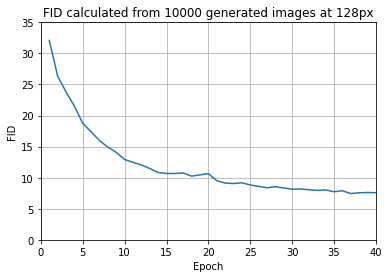

In [ ]:
plt.plot(range(1, len(df["FID"])+1), df["FID"])
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID calculated from 10000 generated images at 128px')
plt.xlim([0,40])
plt.ylim([0,35])
plt.grid()
plt.show()

Generating images from random noise <br>
Use random seed 0 to make sure that the generated images are not cherry-picked

Radomly sampled generate images


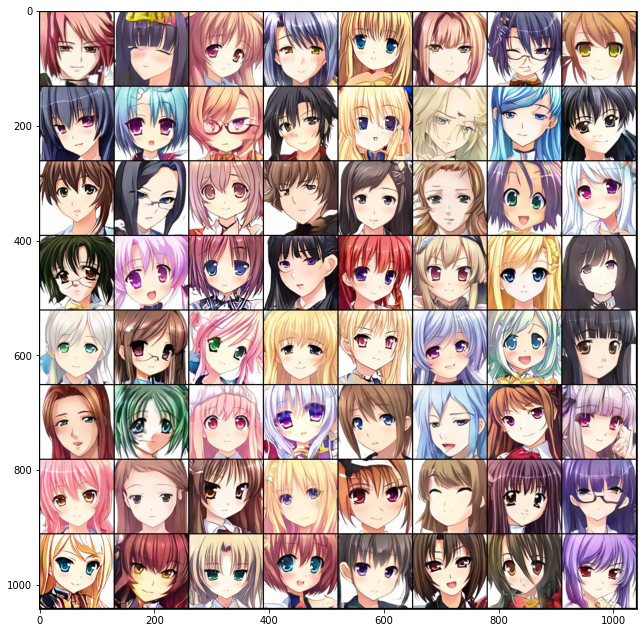

In [ ]:
torch.manual_seed(0)
with torch.no_grad():
    noises = torch.randn(64,Z_DIM).to('cuda')
    imgs = gen_ema(noises, 1, 5)
print("Radomly sampled generate images")
show_tensor_images(imgs, num_images=64, nrow=8, figsize=(11,11))

Generating images from selected seeds

In [ ]:
selected_seeds = torch.load('/content/drive/MyDrive/AnimeFaces_v3/Selected noises 128px.pt')

Selected generated images


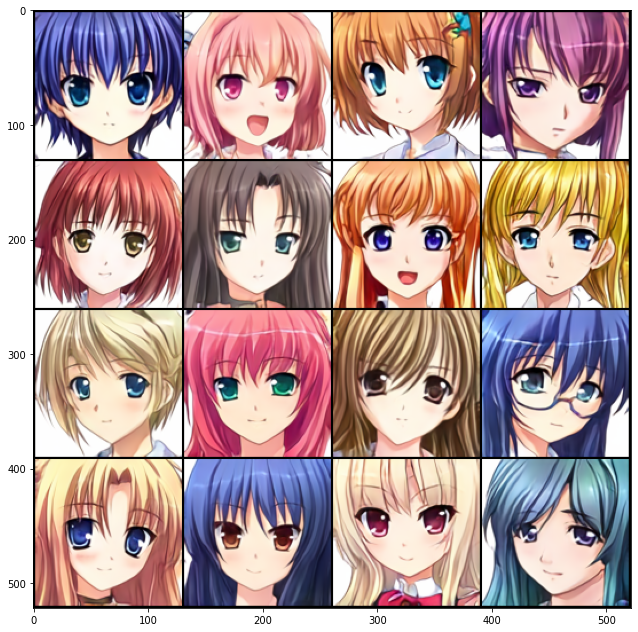

In [ ]:
with torch.no_grad():
    imgs = gen_ema(selected_seeds, 1, 5)
print("Selected generated images")
show_tensor_images(imgs, num_images=16, nrow=4, figsize=(11,11))

Calculate FID from 50000 generated images using the official implementation of FID <br>
Link: https://github.com/mseitzer/pytorch-fid

In [ ]:
for name in os.listdir('generated'):
    full_name = os.path.join('generated', name)
    if os.path.isfile(full_name):
        os.remove(full_name)
os.rmdir('generated')

In [ ]:
generate_by_batch(gen_ema, 1, 5, batch_size=100, n=50000)

In [ ]:
! pip install pytorch-fid

Calculate the final FID score

In [ ]:
! python -m pytorch_fid 'dataset' 'generated' --device cuda:0

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 102MB/s]
100% 813/813 [00:28<00:00, 28.95it/s]
100% 1000/1000 [00:31<00:00, 32.04it/s]
FID:  6.941619807769513
